In [1]:
from SYRIPY import Wavefront, FieldSolver, BeamSolver
from SYRIPY.Optics import FraunhoferProp, CircularAperture, OpticsContainer
from SYRIPY.Tracking import Track, Dipole, FieldContainer
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# In this notebook we will model the edge radiation of a single electron from two seperated dipoles

In [3]:
# Define the magnet setup
d0 = Dipole(torch.tensor([-0.1156, 0, 0]),      # Location (m)
            0.203274830142196,                  # Length (m)
            torch.tensor([0, 0.49051235, 0]),   # Field strength (T)
            None,                               # Direction (not implimented yet)
            0.05)                               # Edge length (m)
d1 = Dipole(torch.tensor([0, 0, 1.0334]), 0.203274830142196, torch.tensor([0, -0.49051235, 0]), None, 0.05)
d2 = Dipole(torch.tensor([0, 0, 2.0668]), 0.203274830142196, torch.tensor([0, -0.49051235, 0]), None, 0.05)
field = FieldContainer([d0, d1, d2])

Text(0, 0.5, 'x (m)')

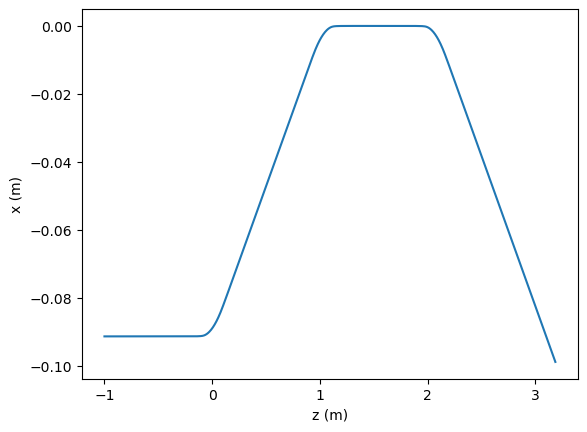

In [4]:
# Define the particle track
gamma = torch.tensor([339.3 / 0.51099890221])  # Lorentz factor
d0 = torch.tensor([-0e-3, 0e-3, 1])            # Initial direction
r0 = torch.tensor([-0.0913563873, 0, -1])      # Initial position
time = torch.linspace(0, 14, 1001)             # Time array samples (ns)

# Define tracking class and track (using c++ implementation, faster but can't do gradients)
track = Track(field, device=device)
track.set_central_params(r0, d0, gamma)
track.sim_central_c(time)

# Plot track
fig, ax = track.plot_track([2, 0])
ax.set_xlabel("z (m)")
ax.set_ylabel("x (m)")

In [5]:
# Define the initial wavefront
wavefnt = Wavefront(2.786062584928902,             # z position of the wavefront (m)
                    3.77e5,                        # Radiation angular frequency (2 pi / ns)
                    [-0.02, 0.02, -0.02, 0.02],    # Wavefront size [x_min, x_max, y_min, y_max] (m)
                    [500, 500],                    # Samples in x and y [n_x, n_y]
                    device=device)                 # device used

In [6]:
# Define the optics
aper = CircularAperture(0.02)  # Aperture with radiuse 0.02m
prop = FraunhoferProp(1)       # Fraunhofer propagation to 1m
optics = OpticsContainer([aper, prop])

Text(0, 0.5, 'x (m)')

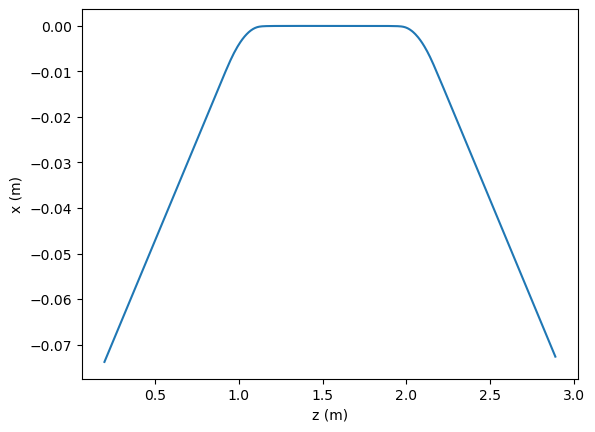

In [7]:
# Define the field solver class
solver = FieldSolver(wavefnt, track)
# Set samples along track (down samples)
solver.set_track(251,       # Number of new samples
                 4,         # Start time
                 13)        # End time
fig, ax = track.plot_track([2, 0])
ax.set_xlabel("z (m)")
ax.set_ylabel("x (m)")

(<Figure size 640x480 with 2 Axes>, <AxesSubplot: >)

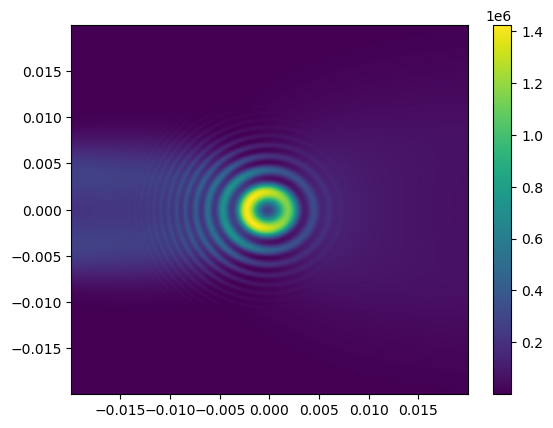

In [8]:
# Solve the field
solver.solve_field()

# Plot the intensity
wavefnt.plot_intensity()

(<Figure size 640x480 with 2 Axes>, <AxesSubplot: >)

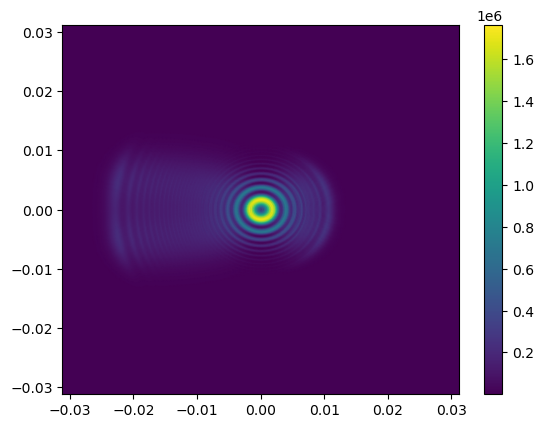

In [9]:
# Propagate the wavefront
optics.propagate(wavefnt)
wavefnt.plot_intensity()